In [418]:
# "The social benefits of emotion variability"
# Analysis script for Study 1 
# Evan W. Carr, 04-25-2018 (Columbia Business School)

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

from plotnine import *
from rpy2.robjects import r, pandas2ri

%matplotlib inline  

# Set working directory to location of data files, and read in .csv's:
rawData = pd.read_csv("manic_exptrun_final_raw_16_12_30.csv")
rawDemog = pd.read_csv("demographics_survey_survey_16_12_30.csv")

rawData.head(20)

,date,time,group,subject,build,blocknum,trialnum,blockcode,trialcode,pretrialpause,...,latency,stimulusnumber1,stimulusitem1,stimulusonset1,stimulusnumber2,stimulusitem2,stimulusonset2,stimulusnumber3,stimulusitem3,stimulusonset3
0,122116,14:49:17,567304211,179466541,5.0.5.0,1,1,expt_intro,expt_intro,0,...,3400,1,"Welcome to the study! During this session, ...",1,1,cbs_logo.jpg,1,1,"If you need to exit the study early, you can d...",1
1,122116,14:49:17,567304211,179466541,5.0.5.0,2,1,lv1_block,lv1_trial,0,...,500,40,WM-006_06_crop.jpg,1,0,0,0,0,0,0
2,122116,14:49:17,567304211,179466541,5.0.5.0,2,2,lv1_block,lv1_trial,0,...,500,57,WM-006_03_crop.jpg,2,0,0,0,0,0,0
3,122116,14:49:17,567304211,179466541,5.0.5.0,2,3,lv1_block,lv1_trial,0,...,500,56,WM-006_02_crop.jpg,5,0,0,0,0,0,0
4,122116,14:49:17,567304211,179466541,5.0.5.0,2,4,lv1_block,lv1_trial,0,...,500,47,WM-006_03_crop.jpg,1,0,0,0,0,0,0
5,122116,14:49:17,567304211,179466541,5.0.5.0,2,5,lv1_block,lv1_trial,0,...,500,52,WM-006_-05_crop.jpg,1,0,0,0,0,0,0
6,122116,14:49:17,567304211,179466541,5.0.5.0,2,6,lv1_block,lv1_trial,0,...,500,53,WM-006_-04_crop.jpg,1,0,0,0,0,0,0
7,122116,14:49:17,567304211,179466541,5.0.5.0,2,7,lv1_block,lv1_trial,0,...,500,59,WM-006_05_crop.jpg,1,0,0,0,0,0,0
8,122116,14:49:17,567304211,179466541,5.0.5.0,2,8,lv1_block,lv1_trial,0,...,500,31,WM-006_-06_crop.jpg,5,0,0,0,0,0,0
9,122116,14:49:17,567304211,179466541,5.0.5.0,2,9,lv1_block,lv1_trial,0,...,500,50,WM-006_06_crop.jpg,1,0,0,0,0,0,0


In [419]:
# All subjects should have 206 observations (rows) in the dataset ...
# Any that have < 206 did not finish the study, and need to be removed before analysis:
rawObsCount = rawData.groupby('subject', as_index=False).size().reset_index(name='counts')
rawObsCount.sort_values(by='counts').head(20)

,subject,counts
150,915107893,28
47,351737790,31
116,749043454,66
118,758787026,69
15,179466541,133
67,495722952,138
139,879005388,171
134,843344189,204
89,597232047,206
103,67169948,206


In [420]:
# Create list of subject ID's to exclude:
exclSbj = rawObsCount.query('counts != 206')
exclSbj = np.array(exclSbj['subject'])
exclSbj

array(['179466541', '351737790', '495722952', '749043454', '758787026',
       '843344189', '879005388', '915107893'], dtype=object)

In [421]:
# Filter to important columns, and exclude subjects that didn't finish the study:
cleanCols = ['subject', 'blocknum', 'trialnum', 'blockcode', 'trialcode', 'response', 'latency', 'stimulusitem1']
cleanData = rawData.loc[~rawData['subject'].isin(exclSbj)][cleanCols]
cleanData.head()

,subject,blocknum,trialnum,blockcode,trialcode,response,latency,stimulusitem1
133,924709483,1,1,expt_intro,expt_intro,57,24485,"Welcome to the study! During this session, ..."
134,924709483,2,1,lv1_block,lv1_trial,0,500,WM-029_-06_crop.jpg
135,924709483,2,2,lv1_block,lv1_trial,0,500,WM-029_-02_crop.jpg
136,924709483,2,3,lv1_block,lv1_trial,0,500,WM-029_-05_crop.jpg
137,924709483,2,4,lv1_block,lv1_trial,0,500,WM-029_05_crop.jpg


In [422]:
# Quickly check subject times to complete the study (should usually be between 3-6 minutes):
completionTimes = cleanData.groupby('subject').agg({'latency': 'sum'}).reset_index()
completionTimes['latency_mins'] = (completionTimes['latency'] / 1000) / 60
completionTimes.head(20)

,subject,latency,latency_mins
0,109539170,196334,3.272233
1,114348112,200295,3.338250
2,114995130,288256,4.804267
3,117977369,206263,3.437717
4,123066218,285536,4.758933
5,123219301,289218,4.820300
6,123720022,195527,3.258783
7,135918963,353241,5.887350
8,136070365,190150,3.169167
9,136742543,237965,3.966083


In [423]:
# Get quick demographics summary, without excluded subjects:
demogSummary = rawDemog.groupby('subject').agg({'age_response': np.mean, "gender_response": pd.Series.unique}).reset_index()
demogSummary = demogSummary[~demogSummary['subject'].isin(exclSbj)]

demogSummary['age_response'].mean()

36.61184210526316

In [424]:
demogSummary['age_response'].std()

11.991193977582748

In [425]:
demogSummary['gender_response'].value_counts()

Male      85
Female    67
Name: gender_response, dtype: int64

In [426]:
# Create column for emotion variability condition ('model_block'):
cleanData = cleanData.join(cleanData['blockcode'].str.split('_', 1, expand=True).rename(columns={0:'model_block', 1:'junk'}))
cleanData = cleanData.drop(['junk'], axis=1)
cleanData.head()

,subject,blocknum,trialnum,blockcode,trialcode,response,latency,stimulusitem1,model_block
133,924709483,1,1,expt_intro,expt_intro,57,24485,"Welcome to the study! During this session, ...",expt
134,924709483,2,1,lv1_block,lv1_trial,0,500,WM-029_-06_crop.jpg,lv1
135,924709483,2,2,lv1_block,lv1_trial,0,500,WM-029_-02_crop.jpg,lv1
136,924709483,2,3,lv1_block,lv1_trial,0,500,WM-029_-05_crop.jpg,lv1
137,924709483,2,4,lv1_block,lv1_trial,0,500,WM-029_05_crop.jpg,lv1


In [427]:
# Map emotion variability condition ('model_block') to umbrella factor: 
varDict = {'expt': 'expt',
           'lv1': 'lv',
           'lv2': 'lv',
           'lv3': 'lv',
           'hv1': 'hv',
           'hv2': 'hv',
           'hv3': 'hv'}

cleanData['model_block'] = cleanData['model_block'].map(varDict)
cleanData.head()

,subject,blocknum,trialnum,blockcode,trialcode,response,latency,stimulusitem1,model_block
133,924709483,1,1,expt_intro,expt_intro,57,24485,"Welcome to the study! During this session, ...",expt
134,924709483,2,1,lv1_block,lv1_trial,0,500,WM-029_-06_crop.jpg,lv
135,924709483,2,2,lv1_block,lv1_trial,0,500,WM-029_-02_crop.jpg,lv
136,924709483,2,3,lv1_block,lv1_trial,0,500,WM-029_-05_crop.jpg,lv
137,924709483,2,4,lv1_block,lv1_trial,0,500,WM-029_05_crop.jpg,lv


In [428]:
# Access and log stimulus model ID codes for inclusion in mixed-effects models (shown later):
ratingsList = ['authenticity_slider', 'power_slider', 'trust_slider', 'happiness_slider']
modelSummary = cleanData.groupby(['subject', 'blocknum']).agg({"stimulusitem1": pd.Series.unique}).reset_index()

modelSummary.head(10)

,subject,blocknum,stimulusitem1
0,109539170,1,"Welcome to the study! During this session, ..."
1,109539170,2,"[WM-029_11_crop.jpg, WM-029_10_crop.jpg, WM-02..."
2,109539170,3,"[WM-033_05_crop.jpg, WM-033_-04_crop.jpg, WM-0..."
3,109539170,4,"[WM-003_-03_crop.jpg, WM-003_-15_crop.jpg, WM-..."
4,109539170,5,"[WM-016_04_crop.jpg, WM-016_-04_crop.jpg, WM-0..."
5,109539170,6,"[WM-006_-02_crop.jpg, WM-006_-03_crop.jpg, WM-..."
6,109539170,7,"[WM-009_11_crop.jpg, WM-009_-13_crop.jpg, WM-0..."
7,109539170,9,All done with the study! Thank you for your p...
8,114348112,1,"Welcome to the study! During this session, ..."
9,114348112,2,"[WM-009_04_crop.jpg, WM-009_03_crop.jpg, WM-00..."


In [429]:
# 'modelSummary' dataframe shows all unique stimuli shown to each subject, by blocknum ...
# Not useful yet, but will be if we can split stimulus names apart:
modelList = []
for i in range(0, modelSummary.shape[0]):
    modelID = modelSummary.iloc[i]['stimulusitem1'][0].split('_', 1)[0]
    modelList.append(modelID)
    
modelSummary['model_id'] = modelList
modelSummary = modelSummary.drop('stimulusitem1', axis=1)

modelSummary.head(10)

,subject,blocknum,model_id
0,109539170,1,W
1,109539170,2,WM-029
2,109539170,3,WM-033
3,109539170,4,WM-003
4,109539170,5,WM-016
5,109539170,6,WM-006
6,109539170,7,WM-009
7,109539170,9,A
8,114348112,1,W
9,114348112,2,WM-009


In [430]:
# Subjects only saw real stimuli in blocknum's 2-7 ...
# Do an inner join with the main data to get only those blocks, then filter to only when subjects gave ratings:
cleanRatings = pd.merge(cleanData, modelSummary, on=('subject', 'blocknum'), how='inner')
cleanRatings = cleanRatings.loc[(cleanRatings['model_block'] != 'expt') & (cleanRatings['trialcode'].isin(ratingsList)), :]
cleanRatings = cleanRatings.drop(['blocknum', 'trialnum', 'blockcode', 'stimulusitem1'], axis=1)

cleanRatings.head(20)

,subject,trialcode,response,latency,model_block,model_id
31,924709483,trust_slider,90,9752,lv,WM-029
32,924709483,power_slider,74,10515,lv,WM-029
33,924709483,authenticity_slider,78,6238,lv,WM-029
34,924709483,happiness_slider,73,6338,lv,WM-029
65,924709483,trust_slider,72,7843,hv,WM-009
66,924709483,happiness_slider,35,8779,hv,WM-009
67,924709483,authenticity_slider,60,5067,hv,WM-009
68,924709483,power_slider,63,3276,hv,WM-009
99,924709483,trust_slider,83,9393,lv,WM-006
100,924709483,happiness_slider,52,8863,lv,WM-006


In [431]:
# Create individual datasets for each major DV:
authenticityData = cleanRatings.query("trialcode == 'authenticity_slider'")
powerData = cleanRatings.query("trialcode == 'power_slider'")
trustData = cleanRatings.query("trialcode == 'trust_slider'")
happinessData = cleanRatings.query("trialcode == 'happiness_slider'")

In [432]:
# Run mixed-effects models on each DV:
#    - fixed = variability (high vs. low)
#    - random = subject & model_id (will add model_id random-effects in R models later)

a_m1 = smf.mixedlm("response ~ model_block", data=authenticityData, groups=authenticityData['subject']).fit()
print(a_m1.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  response  
No. Observations:   912      Method:              REML      
No. Groups:         152      Scale:               372.4380  
Min. group size:    6        Likelihood:          -4050.7868
Max. group size:    6        Converged:           Yes       
Mean group size:    6.0                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         62.353    1.145 54.478 0.000 60.110 64.596
model_block[T.lv] -3.691    1.278 -2.888 0.004 -6.196 -1.186
groups RE         74.976    0.895                           



In [433]:
p_m1 = smf.mixedlm("response ~ model_block", data=powerData, groups=powerData['subject']).fit()
print(p_m1.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  response  
No. Observations:   912      Method:              REML      
No. Groups:         152      Scale:               303.9777  
Min. group size:    6        Likelihood:          -3963.2992
Max. group size:    6        Converged:           Yes       
Mean group size:    6.0                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         53.397    1.058 50.481 0.000 51.324 55.470
model_block[T.lv] -0.491    1.155 -0.425 0.671 -2.754  1.772
groups RE         68.743    0.863                           



In [434]:
t_m1 = smf.mixedlm("response ~ model_block", data=trustData, groups=trustData['subject']).fit()
print(t_m1.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  response  
No. Observations:   912      Method:              REML      
No. Groups:         152      Scale:               359.4894  
Min. group size:    6        Likelihood:          -4045.4022
Max. group size:    6        Converged:           Yes       
Mean group size:    6.0                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         56.877    1.182 48.118 0.000 54.560 59.194
model_block[T.lv] -3.147    1.256 -2.506 0.012 -5.608 -0.686
groups RE         92.543    1.013                           



In [435]:
h_m1 = smf.mixedlm("response ~ model_block", data=happinessData, groups=happinessData['subject']).fit()
print(h_m1.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  response  
No. Observations:   912      Method:              REML      
No. Groups:         152      Scale:               355.0173  
Min. group size:    6        Likelihood:          -4028.7602
Max. group size:    6        Converged:           Yes       
Mean group size:    6.0                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         57.447    1.116 51.462 0.000 55.259 59.635
model_block[T.lv] -6.713    1.248 -5.379 0.000 -9.158 -4.267
groups RE         71.071    0.871                           



In [436]:
# Models suggest that high-variability leads to greater ratings of authenticity, trust, and happiness -- but not power ...

# Push objects to R to confirm analysis
# (statsmodels package in python has trouble fitting certain random-effect structures):

pandas2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [437]:
# Send datasets with ratings to R: 
%R -i authenticityData,powerData,trustData,happinessData

In [438]:
%%R

# Use R to create mixed-effects models with both subject- and stimulus-level random effects:

library(lmerTest)

a_m2 <- lmer(response ~ model_block + (1|subject) + (1|model_id), data=authenticityData)
a_m2_anova <- anova(a_m2)
a_m2_lsmeans <- lsmeans(a_m2)
             
p_m2 <- lmer(response ~ model_block + (1|subject) + (1|model_id), data=powerData)
p_m2_anova <- anova(p_m2)
p_m2_lsmeans <- lsmeans(p_m2)
                          
t_m2 <- lmer(response ~ model_block + (1|subject) + (1|model_id), data=trustData)
t_m2_anova <- anova(t_m2)
t_m2_lsmeans <- lsmeans(t_m2)
                                       
h_m2 <- lmer(response ~ model_block + (1|subject) + (1|model_id), data=happinessData)
h_m2_anova <- anova(h_m2)
h_m2_lsmeans <- lsmeans(h_m2)

In [439]:
# Pull model results back to python:
%R -o a_m2_anova,a_m2_lsmeans,p_m2_anova,p_m2_lsmeans,t_m2_anova,t_m2_lsmeans,h_m2_anova,h_m2_lsmeans

In [440]:
pandas2ri.ri2py(a_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block,2969.095405,2969.095405,1,755.160008,8.301835,0.004073


In [441]:
pandas2ri.ri2py(p_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block,52.306869,52.306869,1,754.488685,0.191392,0.661886


In [442]:
pandas2ri.ri2py(t_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block,2289.823927,2289.823927,1,754.515662,6.999672,0.008322


In [443]:
pandas2ri.ri2py(h_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block,9613.629524,9613.629524,1,754.458618,30.355121,4.938670e-08


In [444]:
# R models confirm python results ...

# Create dataset for plotting:
plotData = pd.DataFrame({
    'rating_type': ['Authenticity', 'Authenticity', 'Trust', 'Trust', 'Power', 'Power', 'Happiness', 'Happiness'],
    'variability': ['High', 'Low', 'High', 'Low', 'High', 'Low', 'High', 'Low'],
    'slider_mean': [pandas2ri.ri2py(a_m2_lsmeans[0]).Estimate[0],
                   pandas2ri.ri2py(a_m2_lsmeans[0]).Estimate[1],
                   pandas2ri.ri2py(t_m2_lsmeans[0]).Estimate[0],
                   pandas2ri.ri2py(t_m2_lsmeans[0]).Estimate[1],
                   pandas2ri.ri2py(p_m2_lsmeans[0]).Estimate[0],
                   pandas2ri.ri2py(p_m2_lsmeans[0]).Estimate[1],
                   pandas2ri.ri2py(h_m2_lsmeans[0]).Estimate[0],
                   pandas2ri.ri2py(h_m2_lsmeans[0]).Estimate[1]],
    'slider_sem': [pandas2ri.ri2py(a_m2_lsmeans[0])['Standard Error'][0],
                   pandas2ri.ri2py(a_m2_lsmeans[0])['Standard Error'][1],
                   pandas2ri.ri2py(t_m2_lsmeans[0])['Standard Error'][0],
                   pandas2ri.ri2py(t_m2_lsmeans[0])['Standard Error'][1],
                   pandas2ri.ri2py(p_m2_lsmeans[0])['Standard Error'][0],
                   pandas2ri.ri2py(p_m2_lsmeans[0])['Standard Error'][1],
                   pandas2ri.ri2py(h_m2_lsmeans[0])['Standard Error'][0],
                   pandas2ri.ri2py(h_m2_lsmeans[0])['Standard Error'][1]]
})

# Adjust numbers to start at 45 (plotnine isn't great at scaling charts to non-zero y-axes):
plotData['slider_mean_45'] = plotData['slider_mean']-45
plotData

,rating_type,slider_mean,slider_sem,variability,slider_mean_45
0,Authenticity,62.3166,1.9389,High,17.3166
1,Authenticity,58.6987,1.9389,Low,13.6987
2,Trust,56.8927,2.5980,High,11.8927
3,Trust,53.7148,2.5980,Low,8.7148
4,Power,53.3915,2.4888,High,8.3915
5,Power,52.9112,2.4888,Low,7.9112
6,Happiness,57.3469,2.7542,High,12.3469
7,Happiness,50.8351,2.7542,Low,5.8351


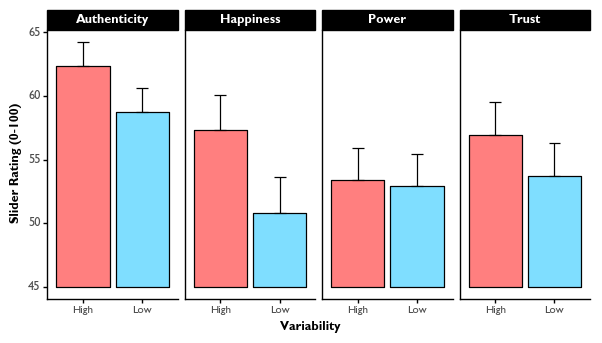

<ggplot: (-9223371927573134392)>

In [445]:
# Use plotnine package to plot using ggplot2 (R) style ...
# Manually recoding y-axis labels using 'slider_mean_45' variable (starting y-axis at zero doesn't look good):
(ggplot(plotData, aes(x='factor(variability)', y='slider_mean_45', fill='factor(variability)')) 
 + geom_errorbar(aes(ymax='slider_mean_45 + slider_sem', ymin='slider_mean_45'), position=position_dodge(width=0.9), width=0.2, color='black')
 + geom_bar(stat='identity', position=position_dodge(width=0.9), alpha=0.5, color='black')
 + scale_fill_manual(values=['red', 'deepskyblue'], guide=False)
 + facet_wrap('~ rating_type', nrow=1)
 + scale_y_continuous(labels=['45', '50', '55', '60', '65'])
 + labs(x='Variability', y='Slider Rating (0-100)')
 + theme_classic()
 + theme(figure_size = (7, 3.5),
         text = element_text(family='Gill Sans MT'),
         axis_text_x = element_text(size = 8),
         axis_title_x = element_text(size = 9, weight = 'bold'),
         axis_text_y = element_text(size = 9),
         axis_title_y = element_text(size = 9, weight = 'bold'),
         axis_line_x = element_line(color = 'black'),
         axis_line_y = element_line(color = 'black'),
         strip_text_x = element_text(weight = 'bold', color = 'white', size = 9), 
         strip_background = element_rect(fill = 'black')))

In [446]:
# Create new dataframe for figure showing high vs. low variability stimulus distributions:
expDesignData = pd.DataFrame({
    'feature': np.repeat(np.linspace(-75, 75, num=31), [2]*31),
    'emotion': ['Angry']*30 + ['Neutral']*2 + ['Happy']*30,
    'variability': ['High Variability', 'Low Variability']*31,
    'count': np.array([1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,3,1,3,1,3,1,3,1,3,0,0,1,3,1,3,1,3,1,3,1,3,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0])
})

expDesignData

,count,emotion,feature,variability
0,1,Angry,-75.0,High Variability
1,0,Angry,-75.0,Low Variability
2,1,Angry,-70.0,High Variability
3,0,Angry,-70.0,Low Variability
4,1,Angry,-65.0,High Variability
5,0,Angry,-65.0,Low Variability
6,1,Angry,-60.0,High Variability
7,0,Angry,-60.0,Low Variability
8,1,Angry,-55.0,High Variability
9,0,Angry,-55.0,Low Variability


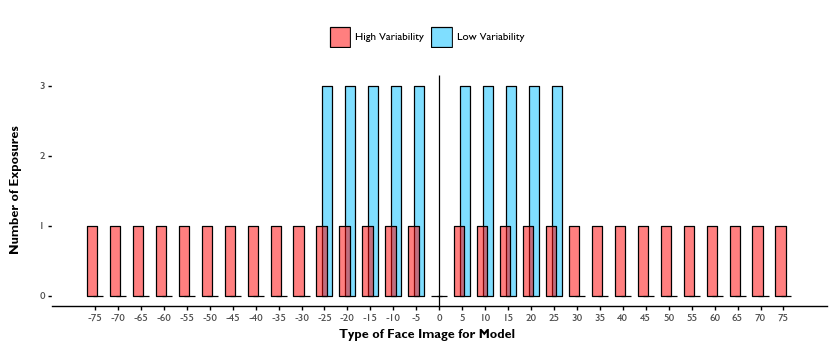

<ggplot: (-9223371927555335494)>

In [447]:
# Generate figure for high vs. low variability stimulus presentation distributions:
(ggplot(expDesignData, aes(x='feature', y='count', fill='variability'))
 + geom_bar(stat='identity', position=position_dodge(width=2.5), alpha=0.5, color='black')
 + scale_fill_manual(values = ['red', 'deepskyblue'])
 + geom_vline(xintercept=0, color='black')
 + scale_x_continuous(breaks=np.linspace(-75, 75, num=31), labels=np.linspace(-75, 75, num=31).astype(int))
 + scale_y_continuous(limits=[0, 3])
 + theme_classic()
 + labs(x='Type of Face Image for Model', y='Number of Exposures\n')
 + theme(figure_size = (10,3),
         text = element_text(family='Gill Sans MT'),
         axis_text_x = element_text(size=8),
         axis_title_x = element_text(size=9, weight='bold'),
         axis_text_y = element_text(size=8),
         axis_title_y = element_text(size=9, weight='bold'),
         axis_line_x = element_line(color='black'),
         axis_line_y = element_line(color='white'),
         legend_title = element_blank(),
         legend_text = element_text(size=8),
         legend_position = 'top'))